In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav
import matplotlib.pyplot as plt
%matplotlib inline 
import skyclean
from skyclean import CMB_data
from astropy.io import fits


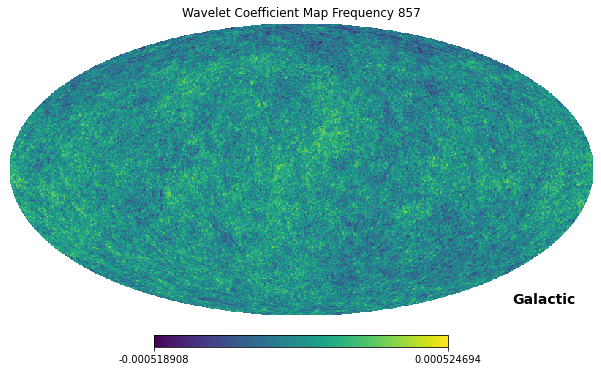

In [12]:
P_857=hp.read_map('/home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_857_mc_0000.fits')
hp.mollview(
        P_857/2.2681,
        coord=["G"],
        title="Wavelet Coefficient Map Frequency 857",
        # unit=r"$1e5$K",
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )

# PLA_Data_Dict["545"][1] = PLA_Data_Dict["545"][1]/58.0356
# PLA_Data_Dict["857"][1] = PLA_Data_Dict["857"][1]/2.2681

In [7]:
l = [2,2]
# print(1/l)


bl = hp.sphtfunc.gauss_beam(10, lmax=5, pol=False)

In [11]:
1/1.47254579e-008

67909603.00120786

In [10]:
bl

array([1.00000000e+000, 1.47254579e-008, 3.19305519e-024, 1.01956015e-047,
       4.79389022e-079, 3.31919010e-118])

In [4]:
local_path = "../../CMB_plot/BeamWf_HFI_R3.01/"

# Open the FITS file
hfi = fits.open(local_path + "Bl_T_R3.01_fullsky_857x857.fits")

In [14]:

temperature_data = hfi[1].data['TEMPERATURE']

In [5]:
hp.read_map(local_path + "Bl_T_R3.01_fullsky_857x857.fits")

ValueError: Wrong pixel number (it is not 12*nside**2)

In [36]:
bl = temperature_data

In [24]:
print(hfi.info())
print(hfi[1].data.shape)    

Filename: ../../CMB_plot/BeamWf_HFI_R3.01/Bl_T_R3.01_fullsky_857x857.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  WINDOW FUNCTION    1 TableHDU        26   4001R x 1C   ['E15.7']   
None
(4001,)


In [22]:
CMB_data_857.show_attributes()

Attributes:
 [['path', '/home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_857_mc_0000.fits'], ['nside', 2048], ['lmax usually 2 * nisde', 4096]]
Maps:
 [['original_hp_map', 'Available'], ['original_mw_map', None], ['reconstructed_hp_map', None], ['reconstructed_mw_map', None]]
Alms:
 [['original_hp_alm', 'Available'], ['reconstructed_hp_alm', None]]
Wavelet_related:
 [['wavelet_coeff', None], ['Scaling_coeff', None]]


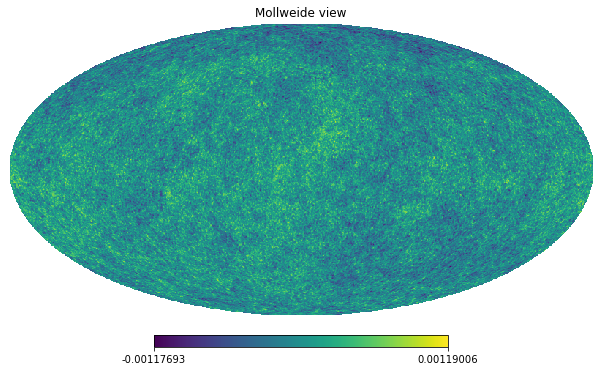

In [23]:
hp.mollview(CMB_data_857.original_hp_map)

In [25]:
CMB_map_path = '/home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_857_mc_0000.fits'
CMB_data_857 = skyclean.CMB_data.CMB_Data(CMB_map_path)

# Store get mw alm
# L max  -  1 
CMB_data_857.original_hp_alm = hp.map2alm(CMB_data_857.original_hp_map, lmax=hfi[1].data.shape[0])
CMB_data_857.original_mw_alm = CMB_data_857.hp_alm_to_mw_alm(CMB_data_857.original_hp_alm, lmax=hfi[1].data.shape[0])

CMB_data_857.original_mw_alm.shape

CMB_Data object created, (use show_attributes() to check the attributes)


(4001, 8001)

In [26]:
hfi[1].data['TEMPERATURE'].shape

(4001,)

In [27]:
CMB_data_857.original_mw_alm.shape

(4001, 8001)

In [ ]:
hfi[1].data['TEMPERATURE']

In [58]:
almxbl = hp.almxfl(CMB_data_857.mw_alm_to_hp_alm(CMB_data_857.original_mw_alm, CMB_data_857.lmax), hfi[1].data['TEMPERATURE'])

IndexError: index 8001 is out of bounds for axis 1 with size 8001

In [37]:
# Deconvolve the beam window function from the CMB data
CMB_data_857_beam_deconvolved = np.zeros(CMB_data_857.original_mw_alm.shape, dtype=np.complex128)

for i in range(CMB_data_857.original_mw_alm.shape[1]):
    CMB_data_857_beam_deconvolved[:, i] = CMB_data_857.original_mw_alm[:, i] / temperature_data
CMB_data_857_beam_deconvolved.shape
# print(CMB_data_857_beam_deconvolved)

(4001, 8001)

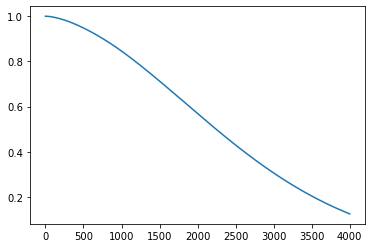

In [42]:
plt.plot(bl)
# plt.yscale('log')
# plt.plot(Standard_bl)
# plt.yscale('log')
# plt.plot(thresholded_bl)
# 

In [ ]:
# alm / beam/ pix * new beam 

In [44]:


def vertical_operation(mw_alm, bl,operation):
    """
    Perform a vertical operation of each column of the original_mw_alm matrix by the thresholded_bl vector.
    
    Parameters:
    original_mw_alm (ndarray): The original matrix to be divided.
    thresholded_bl (ndarray): The vector by which each column of the matrix will be divided.
    
    Returns:
    ndarray: A new matrix with each column of original_mw_alm divided by thresholded_bl.
    """
    # # Ensure thresholded_bl is a column vector for broadcasting
    # thresholded_bl = thresholded_bl[:, np.newaxis]
    
    # # Perform the division
    # beam_deconvolved = original_mw_alm / thresholded_bl
    beam_deconvolved = np.zeros(mw_alm.shape, dtype=np.complex128)

    if operation == '*':
        for i in range(mw_alm.shape[1]):
            beam_deconvolved[:, i] = mw_alm[:, i] * bl
    elif operation == '/':
        for i in range(mw_alm.shape[1]):
            beam_deconvolved[:, i] = mw_alm[:, i] / bl
    else:
        raise ValueError("Operation must be '*' or '/'")


    return beam_deconvolved

# Example usage
# Assuming CMB_data_857.original_mw_alm and thresholded_bl are already defined
# CMB_data_857_beam_deconvolved_1 = vertical_operation(CMB_data_857.original_mw_alm, thresholded_bl,"/")

# # Check the shape
# print(CMB_data_857_beam_deconvolved==CMB_data_857_beam_deconvolved_1)


In [45]:
# Convert arcminutes to radians
def arcmin_to_radians(arcmin):
    return np.radians(arcmin / 60)


# Get the Pixel Window Function for the specified nside
pixwin = hp.sphtfunc.pixwin(CMB_data_857.nside, lmax=hfi[1].data.shape[0]-1, pol=False)

print(pixwin.shape)
# print(pixwin.min())

(4001,)


In [46]:
CMB_data_857_pix_beam_deconvolved = np.zeros(CMB_data_857.original_mw_alm.shape, dtype=np.complex128)

for i in range(CMB_data_857.original_mw_alm.shape[1]):
    CMB_data_857_pix_beam_deconvolved[:, i] = CMB_data_857_beam_deconvolved[:, i] / pixwin
CMB_data_857_pix_beam_deconvolved.shape

(4001, 8001)

In [47]:
fwhm_rad = arcmin_to_radians(5)
Standard_bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=hfi[1].data.shape[0]-1, pol=False)

print(Standard_bl.shape)

(4001,)


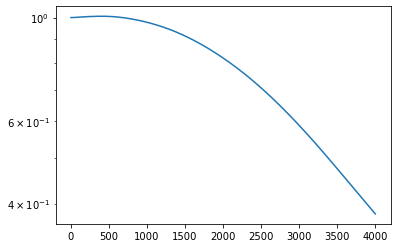

In [48]:
plt.plot(Standard_bl/bl)
plt.yscale('log')

In [21]:
deconvolved_CMB_data_857 = np.zeros(CMB_data_857.original_mw_alm.shape, dtype=np.complex128)   


for i in range(CMB_data_857.original_mw_alm.shape[1]):
    deconvolved_CMB_data_857[:, i] = CMB_data_857_pix_beam_deconvolved[:, i] * Standard_bl
deconvolved_CMB_data_857.shape

(4001, 8001)

In [51]:
processed_857_hp_alm = CMB_data_857.mw_alm_to_hp_alm(deconvolved_CMB_data_857, lmax=deconvolved_CMB_data_857.shape[0])

processed_857_hp_map = hp.alm2map(processed_857_hp_alm, nside=CMB_data_857.nside, lmax=deconvolved_CMB_data_857.shape[0]-1)

hp.mollview(
        CMB_data_857.original_hp_map,
        coord=["G"],
        title="Full Sky CMB at "+"857",
        # unit=r"$\mu$K",
        min=1000, 
        max=2000,
    )


hp.mollview(
        processed_857_hp_map,
        coord=["G"],
        title="Full Sky CMB at "+"857",
        # unit=r"$\mu$K",
        # min=-8570, 
        # max=8570,
    )

# CMB_data_857.plot_mollview(CMB_data_857.original_hp_map, title='Original 857 GHz Map')
# CMB_data_857.plot_mollview(processed_857_hp_map, title='Processed 857 GHz Map')

# CMB_data_857.plot_mollview(CMB_data_857.original_hp_map - processed_857_hp_map, title='Difference Map')

# CMB_data_857.plot_mollview(processed_857_hp_map+(CMB_data_857.original_hp_map - processed_857_hp_map), title='check Map')

NameError: name 'deconvolved_CMB_data_857' is not defined

NameError: name 'processed_857_hp_map' is not defined

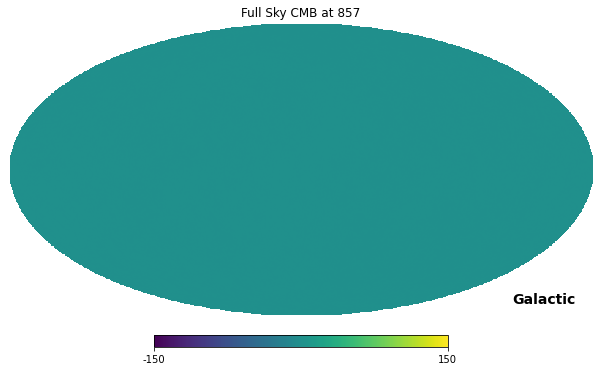

In [50]:
hp.mollview(
        CMB_data_857.original_hp_map,
        coord=["G"],
        title="Full Sky CMB at "+"857",
        # unit=r"$\mu$K",
        min=-150, 
        max=150,
    )


hp.mollview(
        processed_857_hp_map,
        coord=["G"],
        title="Full Sky CMB at "+"857",
        # unit=r"$\mu$K",
        min=-150, 
        max=150,
    )
hp.mollview(
        CMB_data_857.original_hp_map - processed_857_hp_map,
        coord=["G"],
        title='Difference Map',
        # unit=r"$\mu$K",
        min=-150, 
        max=150,
    )
